In [1]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from size_model import SizeModel
sys.path.append('../common')
import common_probs
from sampler import DepthSampler

## Goal
At this point I would like to figure out an analytical way to determine the parameters for the model given any arbitrary distribution that generates generalized strings. 

## Geometric for Offspring Distribution?

One observation that I made eariler is that finding the next failure is kind of like a geometric distribution since we are following some "failure chain" until we reach the first success. Because of this I thought it wouldn't hurt to try to see if a geometric distribution was good for the offspring distribution. In particular, I thought I would try $F \sim Geom_0(1 - c_2)$.

However, this does not work in many cases since this implies that $E[F] = \frac{c_2}{1 - c_2}$. Since I determined last week that we must meet the condition that $E[F] < 1$ this implies that $c_2 < \frac{1}{2}$ which is certainly not the case in many cases.

That being said I thought I would pick $p$ by eye and see if it at least fit as shown in the code below. It looks like this fits somewhat well but does not bring us closer to our original goal.

In [26]:
def plot_trends(num_samples, length, gamma):
    depths = range(1, length + 1)
    alg_trend = get_alg_trend(num_samples, length)[1:]
    plt.plot(depths, alg_trend, label='Algorithm')
    geom = approximate_geometric_dist(0.55, 10)
    model_trend = get_model_trend(num_samples, length, 1, geom)
    plt.plot(depths, model_trend, linestyle='--', label='Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of Threads')
    plt.title('Average Number of Threads vs Depth')
    plt.show()
    
def get_alg_trend(num_samples, length):
    ds = DepthSampler([0.5 for _ in range(4)], length)
    df = ds.draw_samples(num_samples, ['threads'])
    return df.groupby('depth')['threads'].mean().tolist()
    
def get_model_trend(num_samples, length, mu_x, dist):
    model = SizeModel(mu_x, dist)
    return model.do_sims(length, num_samples)

def approximate_geometric_dist(p, possible_offspring):
    dist = [0 for _ in range(possible_offspring + 1)]
    dist[1] = (1 - p) * p
    for i in range(2, possible_offspring + 1):
        dist[i] = (1 - p) * dist[i - 1]
    dist[0] = 1 - sum(dist)
    return dist

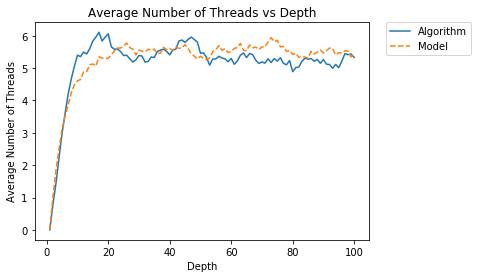

In [28]:
# Constants
NUM_SAMPLES = 1000
LENGTH = 100
GAMMA = 5.5

plot_trends(NUM_SAMPLES, LENGTH, GAMMA)


## Sample/Plot Everything

In attempt to figure out some analytical way to determine the parameters I will try to sample and plot as many aspects of the "threads" as possible. The plots I will look at are:

1. The average number of new threads that occur in each depth. This will obviously be between 0 and 1 since we can have one new thread maximum per depth. This will give insight as to what $\mu_X$ should really be in the model.

2. The average amount of offspring that a thread has in each depth. This will inform what $\mu_Y$ should be in the model. We will also hopefully see that this remain relatively constant regardless of depth. This would be a good thing because it would provide evidence that the offspring distribution is independent of depth. For the sake of this plot each child can only be counted once (i.e. if a child has two parents then it will only count towards one of the threads).

3. The offspring distribution at the second to last level. It seems feasible that the offspring distribution will eventually converge to some distribution. Seeing the shape of this distribution might give some insight to what it is.

4. One thing the current model does not account for is cases where at least two threads share children or merge together. To see how big of a problem this is I will plot the number of times this happens as well as what I will call the "merge degree" (number of parents - 1) for positive merge degrees.

In [14]:
def sample(probs, length, samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(samples, ['threads', 'thread_children', 'new_thread', 'merge_degree'])

def plot_average_new_thread_by_depth(df, length, posn):
    depths = range(length + 1)
    new_thread_trend = df.groupby('depth')['new_thread'].mean().tolist()
    plt.subplot(posn)
    plt.plot(depths, new_thread_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of New Threads')
    plt.title('Average Number of New Threads vs Depth')
    
def plot_average_offspring_by_depth(df, length, posn):
    depths = range(length + 1)
    cpy = df
    cpy['mean_thread_children'] = (cpy['thread_children']
                                  .map(lambda l: 0 if len(l) == 0 else sum(l) / len(l)))
    offspring_trend = cpy.groupby('depth')['mean_thread_children'].mean().tolist()
    plt.subplot(posn)
    plt.plot(depths, offspring_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Thread Offspring')
    plt.title('Average Thread Offspring vs Depth')
    
def plot_asym_offspring_dist(df, length, posn):
    max_sample = 0
    samples = []
    for _, children in df[df['depth'] == length - 1]['thread_children'].iteritems():
        samples += children
        if len(children) > 0:
            curr_max = max(children)
            max_sample = curr_max if curr_max > max_sample else max_sample
    sample_mean = np.mean(samples)
    sample_stddev = np.std(samples)
    int_bins = [-0.5 + i for i in xrange(max_sample + 2)]
    plt.subplot(posn)
    plt.hist(samples, bins=int_bins)
    plt.xlabel('Number of Offspring')
    plt.ylabel('Frequency')
    plt.title('Offspring Distribution; Depth: %d; Samples: %d; Mean: %f; Std Dev: %f' 
              % ((length - 1), len(samples), sample_mean, sample_stddev))
    
def plot_merge_degree_info(df, length, posn):
    if np.isnan(df['merge_degree'].iloc[0]):
        print 'No non-zero merge degrees.'
        return
    depths = range(length + 1)
    cpy = df
    cpy['num_merged'] = cpy['merge_degree'].map(lambda l: len(l))
    num_degree_trend = cpy.groupby('depth')['num_merged'].mean().tolist()
    cpy['mean_merge_degree'] = (cpy['merge_degree']
                                  .map(lambda l: 0 if len(l) == 0 else sum(l) / len(l)))
    mean_degree_trend = cpy.groupby('depth')['mean_merge_degree'].mean().tolist()
    plt.subplot(posn)
    plt.plot(depths, num_degree_trend, label='Number of Merges')
    plt.plot(depths, mean_degree_trend, label='Mean Merge Degree')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Depth')
    plt.ylabel('Amount')
    plt.title('Merge Degree Info')
    
def plot_all(probs, length, samples):
    df = sample(probs, length, samples)
    plt.figure(1, figsize=(16, 12))
    plot_average_new_thread_by_depth(df, length, 221)
    plot_average_offspring_by_depth(df, length, 222)
    plot_asym_offspring_dist(df, length, 223)
    plot_merge_degree_info(df, length, 224)
    plt.show()

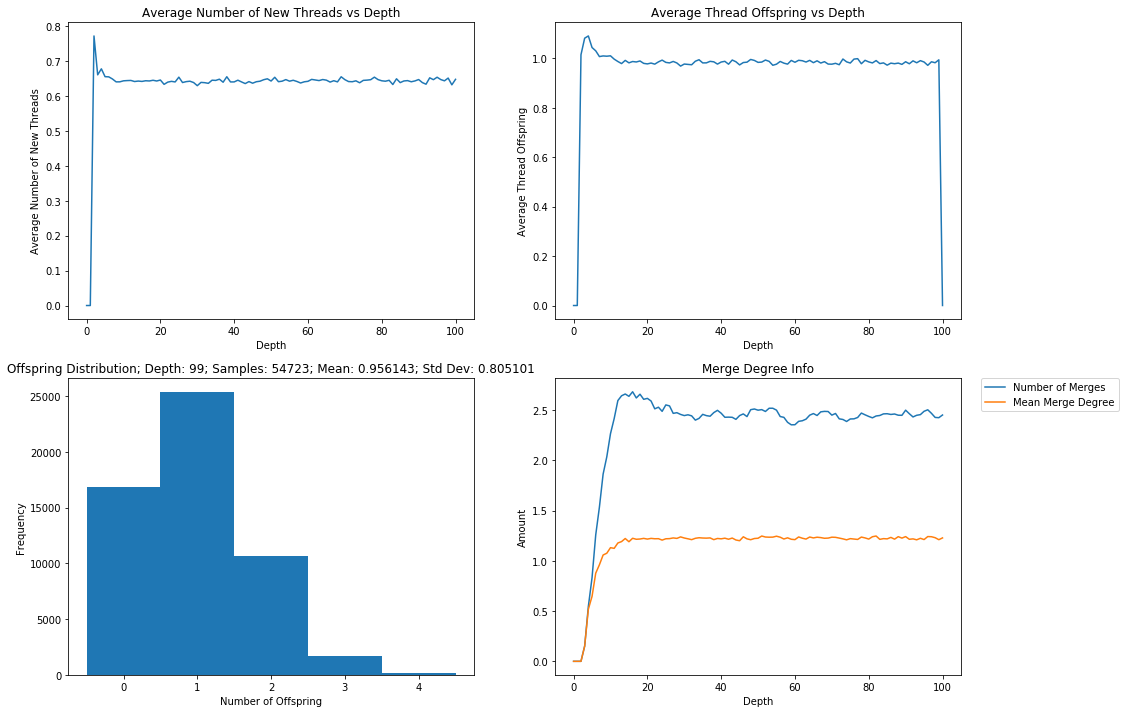

In [16]:
# PARAMETERS
ALPHABET_PROBS = [0.5 for _ in xrange(4)] # Probability of seeing each letter.
LENGTH = 100 # Length of the generalized strings to test.
SAMPLES = 10000 # Number of randomly generated strings to try.

plot_all(ALPHABET_PROBS, LENGTH, SAMPLES)

## Analysis of Plots

1. The first plot of the average number of threads added per depth shows that I was probably wrong to assume that $mu_X$ should be 1. We will also need to be able to determine this analytically.

2. The best part of the second plot is it seems that after some ramp up period the average number of offspring seems to stay at some number close to 1. This hopefully means that the offspring distribution is independent of depth up to some amount of ramp up period.

3. Looking at the offspring distribution the closest thing it looks like to me is a Poisson distribution. This would make some amount of sense because one could think of a thread having a child as a rare event. The biggest difference is that this distribution has a finite support (can only have up to $a$ children).

4. From the last graph it seems that merging actually does pose somewhat of a problem since it happens so often. However, when it does happen it seems that it is usually between just two threads. Hopefully for now we can count threads merging as discontinuations of the thread and ignore this aspect. 

## Offspring Mean Trend

In order to start thinking about the offspring distribution it might also be helpful to see how the mean offspring changes as a function of alphabet size and where generalized strings are generated with uniform probability. This will be done next week.